In [15]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
from scipy.interpolate import griddata
import os

In [16]:
shapefile_path = r"E:\Downloads\bgd_adm_bbs_20201113_shp\bgd_adm_bbs_20201113_SHP\bgd_admbnda_adm1_bbs_20201113.shp"

In [17]:
model_path = r"F:\SUST Research Project\Final report data and figures\processed hist"
model_files = [f for f in os.listdir(model_path) if f.endswith('.csv')]
model_arr = [pd.read_csv(os.path.join(model_path, f),  parse_dates=True, index_col="Date") for f in model_files]

In [18]:
model_arr = [df.rename(columns={'Precipitation': 'Obs. Precipitation'}).bfill() for df in model_arr]

In [138]:
mean = []

for df in model_arr:
    data = {}
    data['district'] = df['district'].iloc[0]
    data['station_id'] = df['station_id'].iloc[0]
    # data['lat'] = df['lat'].iloc[0]
    # data['lon'] = df['lon'].iloc[0] #'ACCESS-ESM1-5-NBC', 'CanESM5-NBC',

    # data['data_range'] = df.index[0].strftime('%Y-%m-%d') + ' to ' + df.index[-1].strftime('%Y-%m-%d')
    data['start'] = df.index[0].year
    data['end'] = df.index[-1].year
    for var in ['ACCESS-ESM1-5-NBC', 'ACCESS-ESM1-5-eQM', 'CanESM5-NBC','CanESM5-eQM','Obs. Precipitation']:
        # data[f'{var} mean'] = df[var].mean()
        # data[f'{var} std'] = df[var].std()
        # data[f'{var} lag1'] = df[var].autocorr(lag=1)
        # data[f'{var} lag0'] = df[var].corr(df['Obs. Precipitation'], method='pearson')
        # data[f'{var} cov'] = df[var].std() / df[var].mean() if df[var].mean() != 0 else np.nan
        # data[var] = df[var].mean()
        # data[var] = df[var].std()
        # data[var] = df[var].corr(df['Obs. Precipitation'], method='pearson')
        data[var] = df[var].quantile(0.95)
    mean.append(data)
mean_df = pd.DataFrame(mean)
mean_df.rename(columns={'Precipitation': 'Observed Precipitation'}, inplace=True)
# mean_df.to_csv('stations information.csv', index=False)

In [139]:
mean_df.set_index('district', inplace=True)
mean_df.sort_values(by='Obs. Precipitation', inplace=True, ascending=False)

In [ ]:
# Date range and station information

# # Sort to make it more readable (optional)
# mean_df = mean_df.sort_values(by='start', ascending=True)

# stations = mean_df.index
# starts = mean_df['start']
# durations = mean_df['end'] - mean_df['start']

# # Create the plot
# fig, ax = plt.subplots(figsize=(18, 8))

# # Plot horizontal bars
# ax.barh(stations, durations, left=starts, color='steelblue', edgecolor='black', height=0.6)

# # Add only start year labels
# for i, (start) in enumerate(starts):
#     ax.text(start - 0.5, i, str(start), va='center', ha='right', fontsize=9, color='black')

# # Set axis limits and labels
# ax.set_xlim(1975, max(mean_df['end']) + 2)
# ax.set_xlabel('Year')

# # Add grid for better readability
# ax.grid(True, axis='x', linestyle='--', alpha=0.5)

# # Improve layout
# plt.tight_layout()
# plt.show()


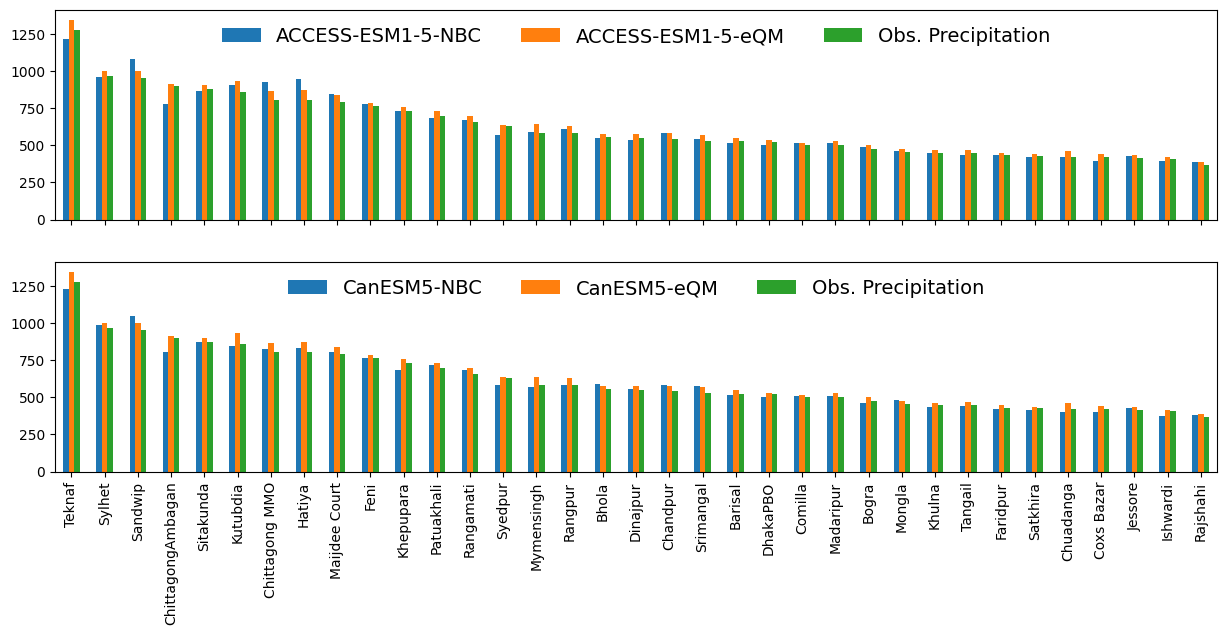

In [141]:
fig, axes = plt.subplots(figsize=(15, 20), nrows=2, ncols=1)
axes = axes.flatten()

mean_df[['ACCESS-ESM1-5-NBC', 'ACCESS-ESM1-5-eQM', 'Obs. Precipitation']].plot(kind='bar', figsize=(15, 6), xlabel='', ax=axes[0])
mean_df[['CanESM5-NBC','CanESM5-eQM', 'Obs. Precipitation']].plot(kind='bar', figsize=(15, 6), xlabel='', ax=axes[1])
axes[0].tick_params(axis='x', labelbottom=False)  # disables only x-axis tick labels
axes[0].legend(loc='upper center', ncol=3, frameon=False, fontsize=14)
axes[1].legend(loc='upper center', ncol=3, frameon=False, fontsize=14)
# axes[0].set_ylim(0, 1)
# axes[1].set_ylim(0, 1)


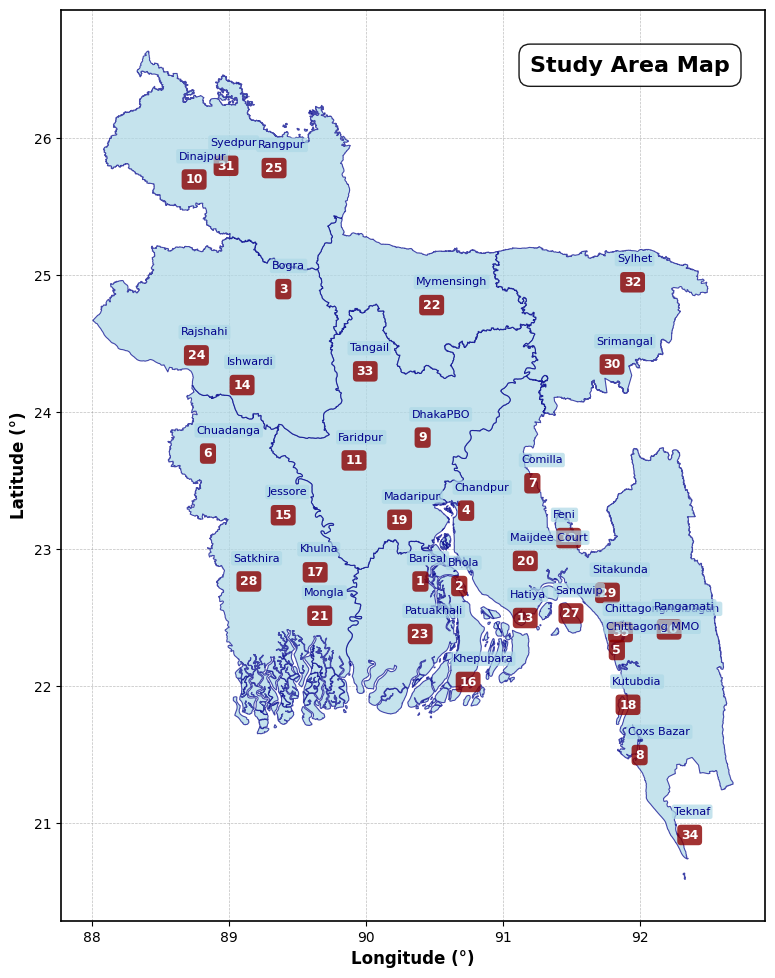

In [39]:
# Set style for better aesthetics
plt.style.use('default')
fig, ax = plt.subplots(figsize=(12, 10))

# Load and plot shapefile
shapefile = gpd.read_file(shapefile_path).to_crs(epsg=4326)
shapefile.plot(ax=ax, color='lightblue', edgecolor='darkblue', linewidth=0.8, alpha=0.7)

# Create GeoDataFrame from station coordinates
points = [Point(xy) for xy in zip(mean_df['lon'], mean_df['lat'])]
gdf = gpd.GeoDataFrame(mean_df, geometry=points, crs="EPSG:4326")

# Don't plot station points - we'll show only text labels

# Add station IDs as labels
for idx, row in gdf.iterrows():
    ax.annotate(
        text=str(int(row['station_id'])),
        xy=(row['lon'], row['lat']),
        xytext=(0, 0),  # offset from point
        textcoords='offset points',
        fontsize=9,
        fontweight='bold',
        color='white',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='darkred', alpha=0.8, edgecolor='none'),
        ha='left',
        va='bottom'
    )

# Add district names (assuming districts are available in the data)
# If districts are in the mean_df, use them; otherwise use shapefile districts
if 'district' in mean_df.columns:
    # Add district labels for each station
    for idx, row in gdf.iterrows():
        ax.annotate(
            text=str(row['district']),
            xy=(row['lon'], row['lat']),
            xytext=(-5, 25),  # offset below the station ID
            textcoords='offset points',
            fontsize=8,
            fontweight='normal',
            color='darkblue',
            bbox=dict(boxstyle='round,pad=0.2', facecolor='lightblue', alpha=0.7, edgecolor='none'),
            ha='left',
            va='top'
        )
else:
    # Add district names from shapefile centroids
    if 'district' in shapefile.columns or 'DISTRICT' in shapefile.columns or 'name' in shapefile.columns:
        district_col = 'district' if 'district' in shapefile.columns else ('DISTRICT' if 'DISTRICT' in shapefile.columns else 'name')
        for idx, row in shapefile.iterrows():
            centroid = row.geometry.centroid
            ax.annotate(
                text=str(row[district_col]),
                xy=(centroid.x, centroid.y),
                fontsize=10,
                fontweight='bold',
                color='navy',
                ha='center',
                va='center',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor='navy', linewidth=1)
            )

# Add grid
ax.grid(True, linestyle='--', alpha=0.5, color='gray', linewidth=0.5)
ax.set_axisbelow(True)  # Put grid behind other elements

# Add "Study Area Map" text in upper right
ax.text(0.95, 0.95, 'Study Area Map', 
        transform=ax.transAxes,
        fontsize=16, 
        fontweight='bold',
        ha='right', 
        va='top',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9, edgecolor='black', linewidth=1))

# Enhance axes
ax.set_xlabel('Longitude (°)', fontsize=12, fontweight='bold')
ax.set_ylabel('Latitude (°)', fontsize=12, fontweight='bold')
ax.tick_params(axis='both', which='major', labelsize=10)

# Set aspect ratio to equal for proper geographic representation
ax.set_aspect('equal', adjustable='box')

# Add a subtle border around the plot
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.2)

# Tight layout with padding
plt.tight_layout(pad=1.5)
plt.show()

In [5]:
model_arr[0]

,Obs. Precipitation,district,station_id,lat,lon,ACCESS-ESM1-5,CanESM5,ACCESS-ESM1-5-eQM,ACCESS-ESM1-5-NBC,CanESM5-eQM,CanESM5-NBC
Date,,,,,,,,,,,
1978-12-01,0.0,Barisal,1.0,22.716667,90.366667,3.593860,3.606686,3.563510,0.000000,12.000000,0.000000
1979-01-01,1.0,Barisal,1.0,22.716667,90.366667,4.875633,2.250929,7.000000,0.000000,7.000000,0.000000
1979-02-01,14.0,Barisal,1.0,22.716667,90.366667,53.262992,0.333100,227.251732,38.940354,1.000000,6.900331
1979-03-01,30.0,Barisal,1.0,22.716667,90.366667,50.851829,84.870605,218.484988,77.254759,241.485981,263.584780
1979-04-01,38.0,Barisal,1.0,22.716667,90.366667,6.549988,25.932893,15.120092,31.611093,97.785047,119.332161
...,...,...,...,...,...,...,...,...,...,...,...
2014-08-01,253.0,Barisal,1.0,22.716667,90.366667,410.835303,301.867235,484.575058,342.485136,674.313084,448.203125
2014-09-01,254.0,Barisal,1.0,22.716667,90.366667,166.801162,191.026927,356.027714,249.848682,404.514019,244.391845
2014-10-01,66.0,Barisal,1.0,22.716667,90.366667,141.730308,35.430017,325.491917,306.058390,146.995327,84.634610


In [6]:
def plot_all_model_stats(df, figsize=(14, 10), title="Bar Chart"):
    """
    Plots grouped bar charts (mean, std, lag0, lag1) for observed, CanESM5,
    and ACCESS-ESM1-5 across raw, NBC, and eQM data in a 2x2 layout.

    Parameters:
    -----------
    df : pd.DataFrame
        Must include columns:
        - 'Obs. Precipitation'
        - 'CanESM5', 'CanESM5-NBC', 'CanESM5-eQM'
        - 'ACCESS-ESM1-5', 'ACCESS-ESM1-5-NBC', 'ACCESS-ESM1-5-eQM'

    figsize : tuple
        Size of the entire figure
    """

    metrics = ['mean', 'std', 'lag0', 'lag1']
    methods = ['', '-NBC', '-eQM']
    categories = ['Raw', 'NBC', 'eQM']
    obs_col = 'Obs. Precipitation'

    def compute_stat(col, metric, ref=None):
        if metric == 'mean':
            return df[col].mean()
        elif metric == 'std':
            return df[col].std()
        elif metric == 'lag0':
            return df[col].corr(df[ref]) if ref else 1
        elif metric == 'lag1':
            return df[col].autocorr(lag=1)

    # Prepare stats for all metrics
    stats_by_metric = {}
    for metric in metrics:
        stats_by_metric[metric] = {
            'Obs': [compute_stat(obs_col, metric) for _ in methods],
            'CanESM5': [compute_stat('CanESM5' + m, metric, obs_col) for m in methods],
            'ACCESS-ESM1-5': [compute_stat('ACCESS-ESM1-5' + m, metric, obs_col) for m in methods],
        }

    fig, axs = plt.subplots(2, 2, figsize=figsize)
    axs = axs.flatten()

    bar_width = 0.28
    group_spacing_factor = 1.5  # controls inter-group spacing

    x = np.arange(len(categories)) * (bar_width * 3 * group_spacing_factor)
    offsets = [-bar_width, 0, bar_width]  # 3 bars per group
    
    colors = ['gray', 'darkorange', 'steelblue']
    labels = ['Observed', 'CanESM5', 'ACCESS-ESM1-5']

    for ax, metric in zip(axs, metrics):
        stats = stats_by_metric[metric]
        for i, (model, offset, color) in enumerate(zip(stats.keys(), offsets, colors)):
            values = stats[model]
            xpos = x + offset
            ax.bar(xpos, values, width=bar_width, label=labels[i], color=color)
        ax.set_xticks(x)
        ax.set_xticklabels(categories)
        ax.set_ylabel(metric.capitalize())
        # ax.set_title(f'{metric.capitalize()} Comparison')
        ax.grid(axis='y', linestyle='--', alpha=0.5)

    # Single legend
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=3, fontsize=11, frameon=False)
    fig.suptitle(title)

    plt.tight_layout(rect=[0, 0.05, 1, 1])  # Leave space at bottom for legend
    # plt.show()
    plt.savefig(rf"F:\SUST Research Project\hist\{title}.png")

In [7]:
# for df in model_arr:
#     plot_all_model_stats(df, figsize=(8, 5), title=df['district'].iloc[0])


In [8]:
# for i,dist in enumerate([s.split("_")[3] for s in model_files]):
#     model_arr[i]['district'] = dist

C:\Users\Acer\AppData\Local\Temp\ipykernel_6032\221361209.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 1])


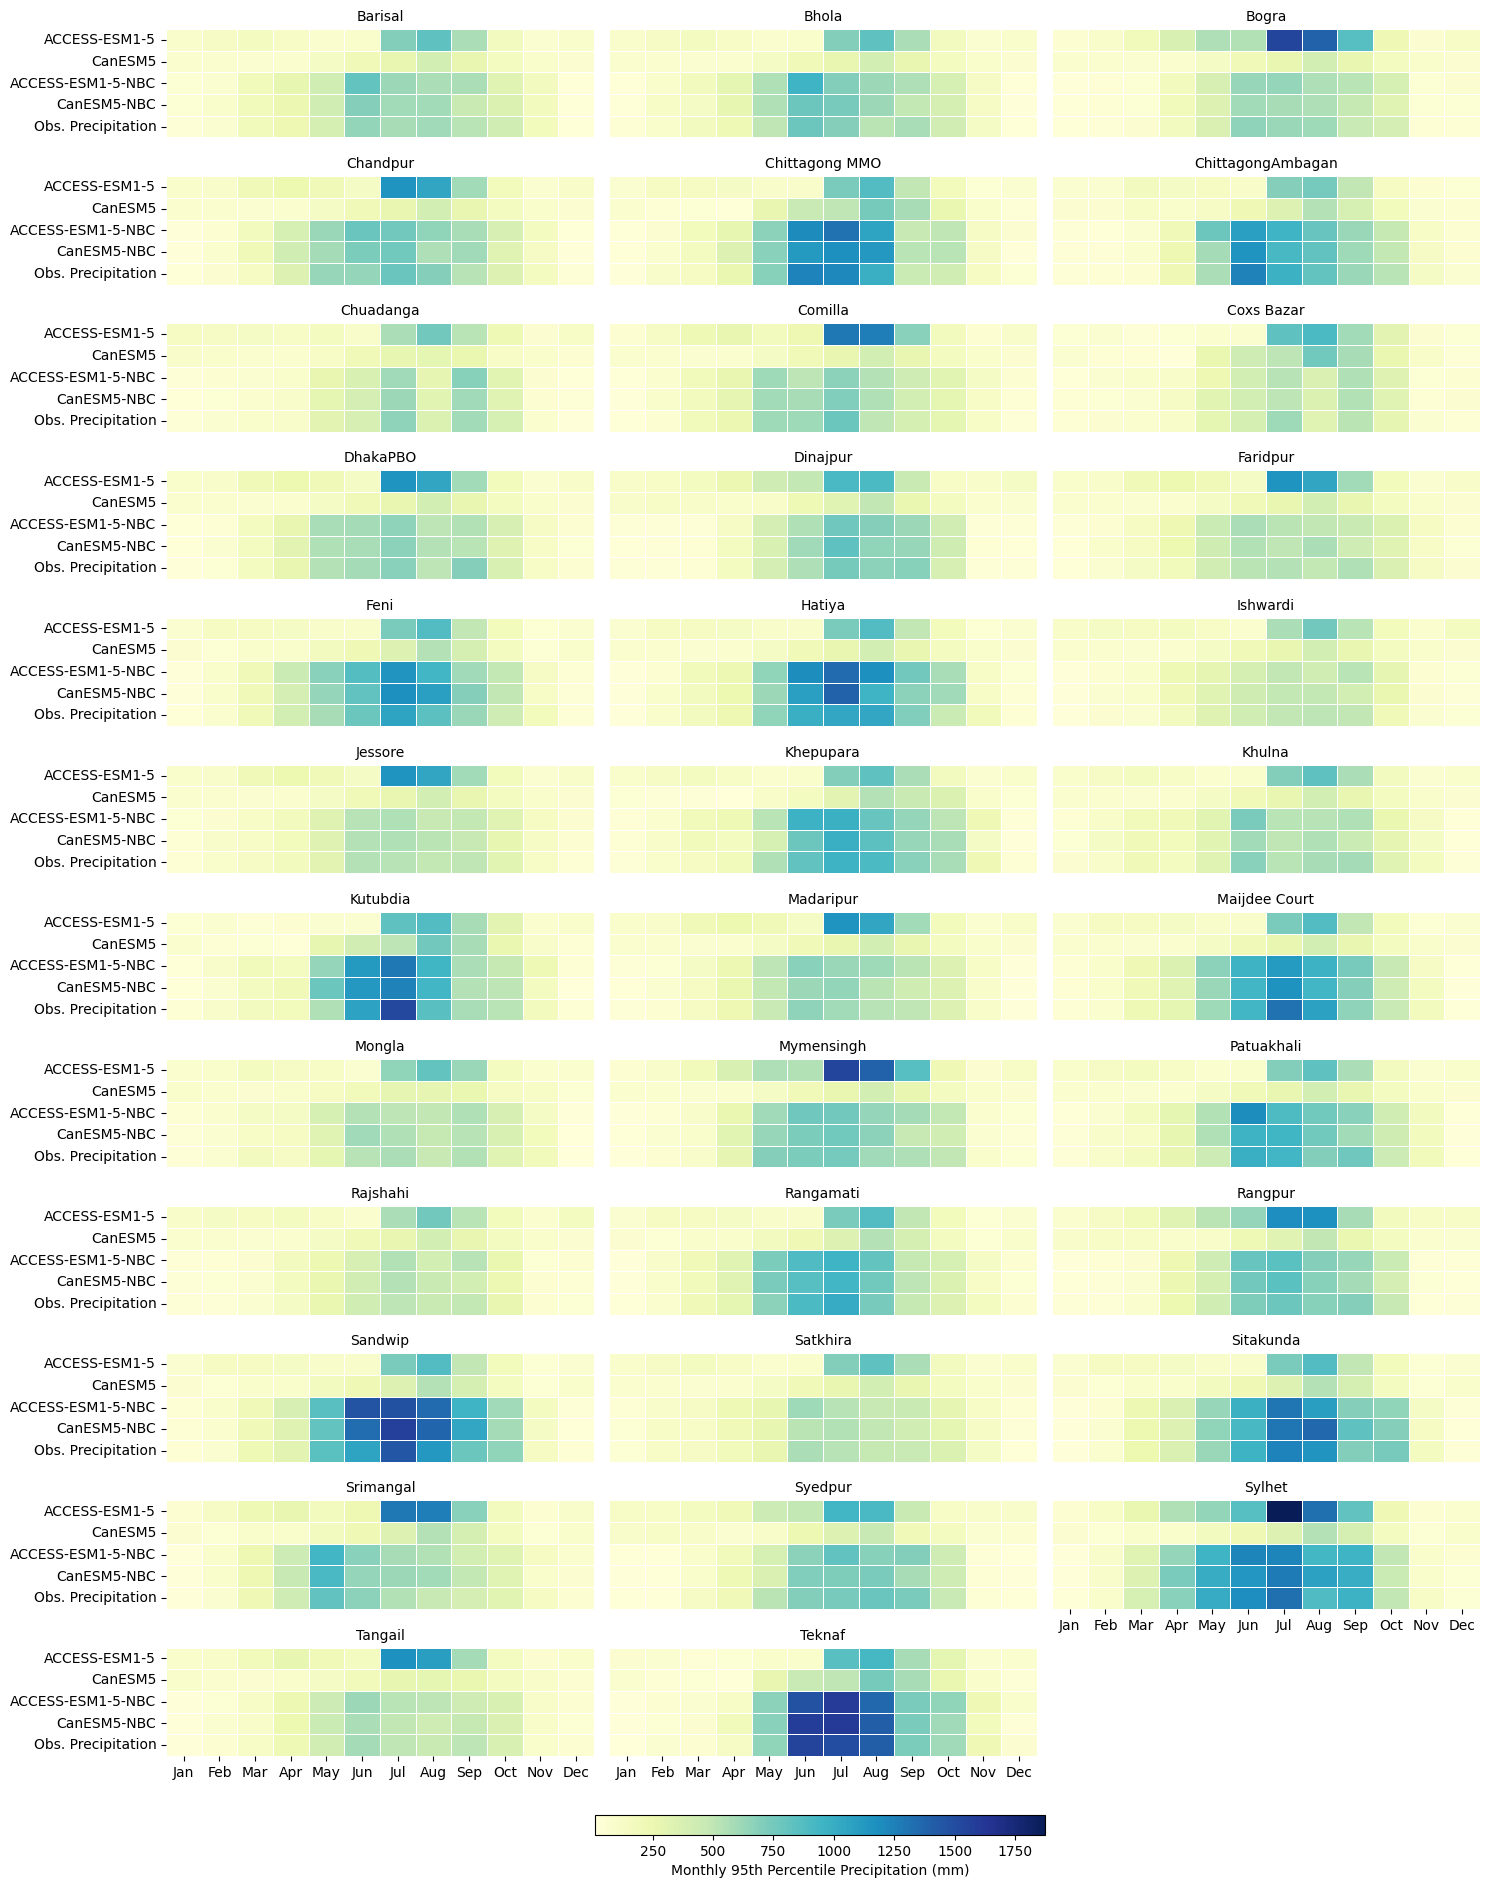

In [9]:
fig, ax = plt.subplots(figsize=(15, 20), nrows=12, ncols=3)
ax = ax.flatten()

# Pre-compute global vmin and vmax for consistent color scale
vmin, vmax = float('inf'), float('-inf')
for df in model_arr:
    df = df.loc[:, ['ACCESS-ESM1-5', 'CanESM5','ACCESS-ESM1-5-NBC', 'CanESM5-NBC', 'Obs. Precipitation']]
    
    # mask = df[df.columns] <= 1
    # monthly_mean = df[mask].groupby(df.index.month).count().T
    #=========montly mean precipitation==========
    # monthly_mean = df.resample('MS').sum()
    monthly_mean = df.groupby(df.index.month).quantile(0.95).T
    # ==========Mean daily precipitation in a month==========
    # monthly_mean = df.groupby(df.index.month).mean().T
    vmin = min(vmin, monthly_mean.min().min())
    vmax = max(vmax, monthly_mean.max().max())

# Plot all subplots
for i, df in enumerate(model_arr):
    district = df['district'].iloc[0]
    df = df.loc[:, ['ACCESS-ESM1-5', 'CanESM5','ACCESS-ESM1-5-NBC', 'CanESM5-NBC', 'Obs. Precipitation']]
    
    # mask = df[df.columns] <= 1 'ACCESS-ESM1-5-NBC', 'CanESM5-NBC',
    # monthly_mean = df[mask].groupby(df.index.month).count().T
    #=========montly mean precipitation==========
    # monthly_mean = df.resample('MS').sum()
    monthly_mean = df.groupby(df.index.month).quantile(0.95).T
    # ==========Mean daily precipitation in a month==========
    # monthly_mean = df.groupby(df.index.month).mean().T
    # monthly_mean.rename(index={'Precipitation': 'Obs. Precipitation'}, inplace=True)

    sns.heatmap(
        monthly_mean,
        ax=ax[i],
        vmin=vmin,
        vmax=vmax,
        cmap="YlGnBu",
        cbar=False,  # disable individual colorbars
        fmt=".1f",
        linewidths=0.5,
        xticklabels=False,
        yticklabels=(i % 3 == 0),  # only first column shows y-ticks
    )
    ax[i].set_title(district, fontsize=10)


    ax[i].set_xlabel("")


ax[-2].set_xticks(np.arange(12) + 0.5)
ax[-2].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax[-3].set_xticks(np.arange(12) + 0.5)
ax[-3].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax[-4].set_xticks(np.arange(12) + 0.5)
ax[-4].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
# Add shared horizontal colorbar at the bottom
cbar_ax = fig.add_axes([0.4, 0.08, 0.3, 0.01])  # [left, bottom, width, height]
norm = plt.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap="YlGnBu", norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Monthly 95th Percentile Precipitation (mm)')
ax[-1].set_axis_off()  # Hide the last axis to avoid clutter
plt.tight_layout(rect=[0, 0.1, 1, 1]) 
plt.show()

In [10]:
def plot_precipitation_cdf(series, label, ax):
    """
    Plot empirical CDF of a single precipitation series on a given axis.

    Parameters:
    -----------
    series : pd.Series or np.ndarray
        Bias-corrected or raw precipitation data.

    label : str
        Label for the series (e.g., 'ACCESS-ESM1-5-eQM') to show in the legend.

    ax : matplotlib.axes.Axes
        Matplotlib axis to plot on.
    """

    # Drop NaNs and sort
    data = np.sort(np.array(pd.Series(series).dropna()))

    # Create empirical CDF values
    cdf = np.linspace(0, 1, len(data))

    # Plot CDF
    ax.plot(data, cdf, label=label, linewidth=2)

    # Plot formatting
    ax.set_xlabel('Precipitation (mm)', fontsize=12)
    ax.set_ylabel('Cumulative Probability', fontsize=12)
    # ax.set_title(f'CDF - {label}', fontsize=14)
    # ax.legend()
    ax.grid(True)
    ax.set_xlim(left=0)
    ax.set_ylim(0, 1.05)

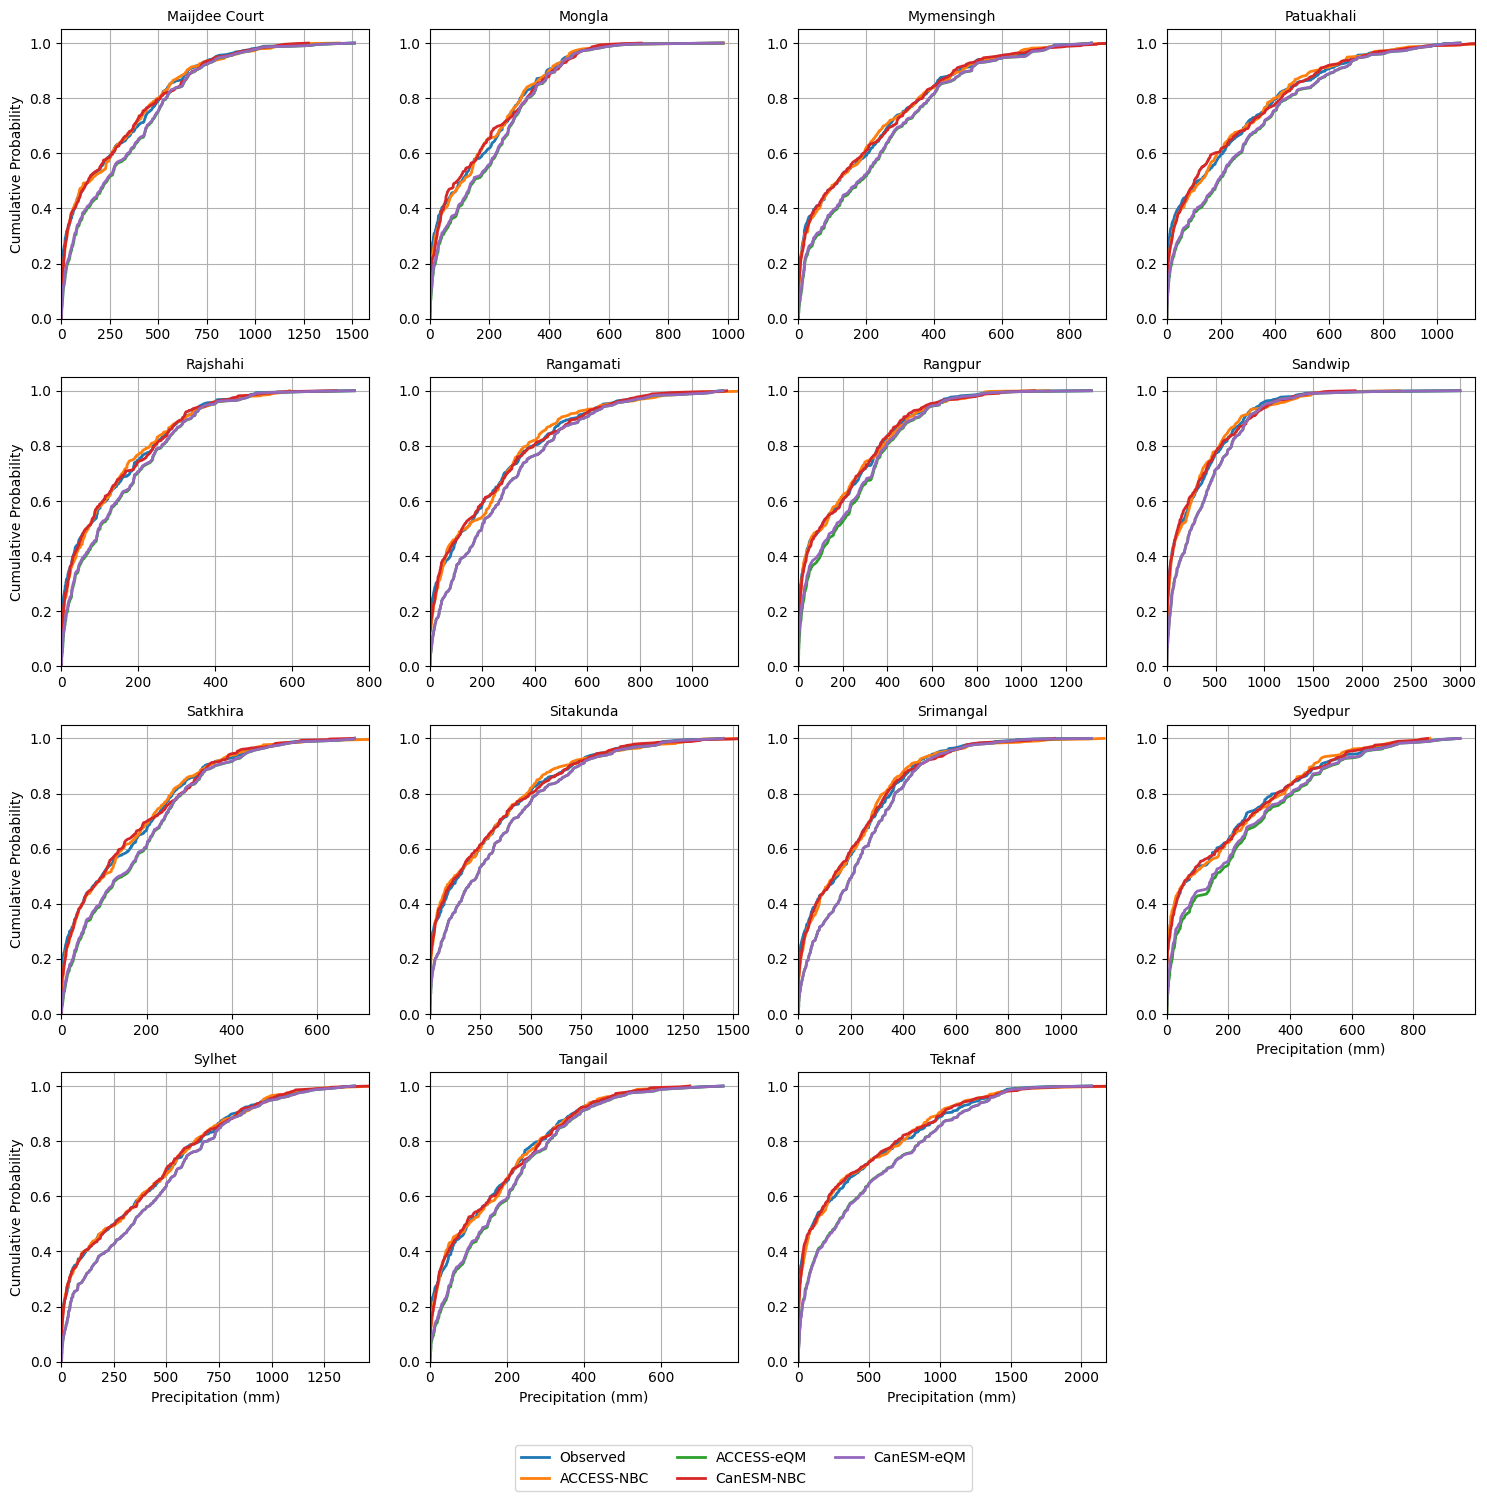

In [11]:
fig, ax = plt.subplots(figsize=(15, 15), nrows=4, ncols=4)
ax = ax.flatten()

for i, df in enumerate(model_arr[20:]):
    plot_precipitation_cdf(df['Obs. Precipitation'], label='Observed', ax=ax[i])
    plot_precipitation_cdf(df['ACCESS-ESM1-5-NBC'], label='ACCESS-NBC', ax=ax[i])
    plot_precipitation_cdf(df['ACCESS-ESM1-5-eQM'], label='ACCESS-eQM', ax=ax[i])
    plot_precipitation_cdf(df['CanESM5-NBC'], label='CanESM-NBC', ax=ax[i])
    plot_precipitation_cdf(df['CanESM5-eQM'], label='CanESM-eQM', ax=ax[i])

    ax[i].set_title(df['district'].iloc[0], fontsize=10)

    # Show y-label only on first column
    if i % 4 == 0:
        ax[i].set_ylabel('Cumulative Probability', fontsize=10)
    else:
        ax[i].set_ylabel('')

    # Show x-label only on last row
    if i >= 12:
        ax[i].set_xlabel('Precipitation (mm)', fontsize=10)
        ax[-5].set_xlabel('Precipitation (mm)', fontsize=10)
    else:
        ax[i].set_xlabel('')
ax[-1].set_axis_off()
# Create shared legend
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, fontsize=10)

# Adjust layout to make space for legend
fig.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()


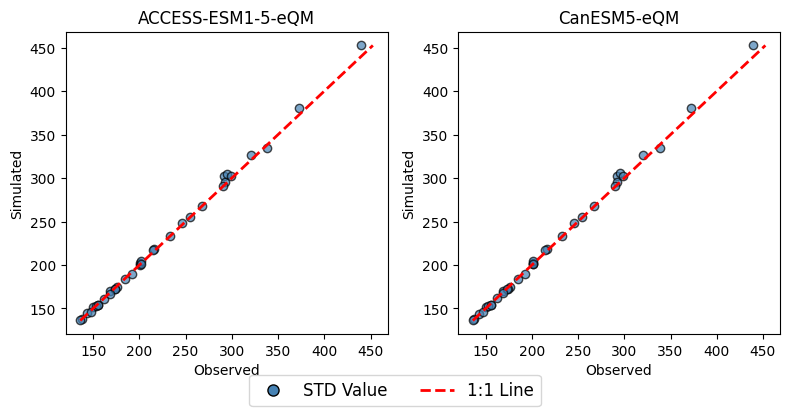

In [12]:
from Scatter_Identity_Line import scatter_with_identity_line
scatter_with_identity_line(
    data_arr=model_arr,
    observed_col='Obs. Precipitation',
    model_cols=['ACCESS-ESM1-5-eQM', 'CanESM5-eQM'],
    figsize=(8, 4),
    rows=1,
    cols=2,
    method='std'  # or 'mean', 'std', 'lag1'
)

In [13]:
mean = []

for df in model_arr:
    data = {}
    data['lat'] = df['lat'].iloc[0]
    data['lon'] = df['lon'].iloc[0]
    data['district'] = df['district'].iloc[0]
    for var in ['ACCESS-ESM1-5', 'CanESM5','ACCESS-ESM1-5-NBC', 'CanESM5-NBC', 'Obs. Precipitation']:
        data[var] = df[var].mean()
    mean.append(data)
mean_df = pd.DataFrame(mean)
mean_df.head()

,lat,lon,district,ACCESS-ESM1-5,CanESM5,ACCESS-ESM1-5-NBC,CanESM5-NBC,Obs. Precipitation
0,22.716667,90.366667,Barisal,110.655505,80.604554,172.022657,171.982713,172.565820
1,22.683333,90.650000,Bhola,110.655505,80.604554,182.063857,182.000911,181.847575
2,24.850000,89.366667,Bogra,268.348967,80.782790,146.854759,146.855965,146.854167
3,23.233333,90.700000,Chandpur,170.504375,80.782790,172.835859,174.098663,174.532407
4,22.216667,91.800000,Chittagong MMO,117.892014,142.606122,215.986152,216.160729,218.572748


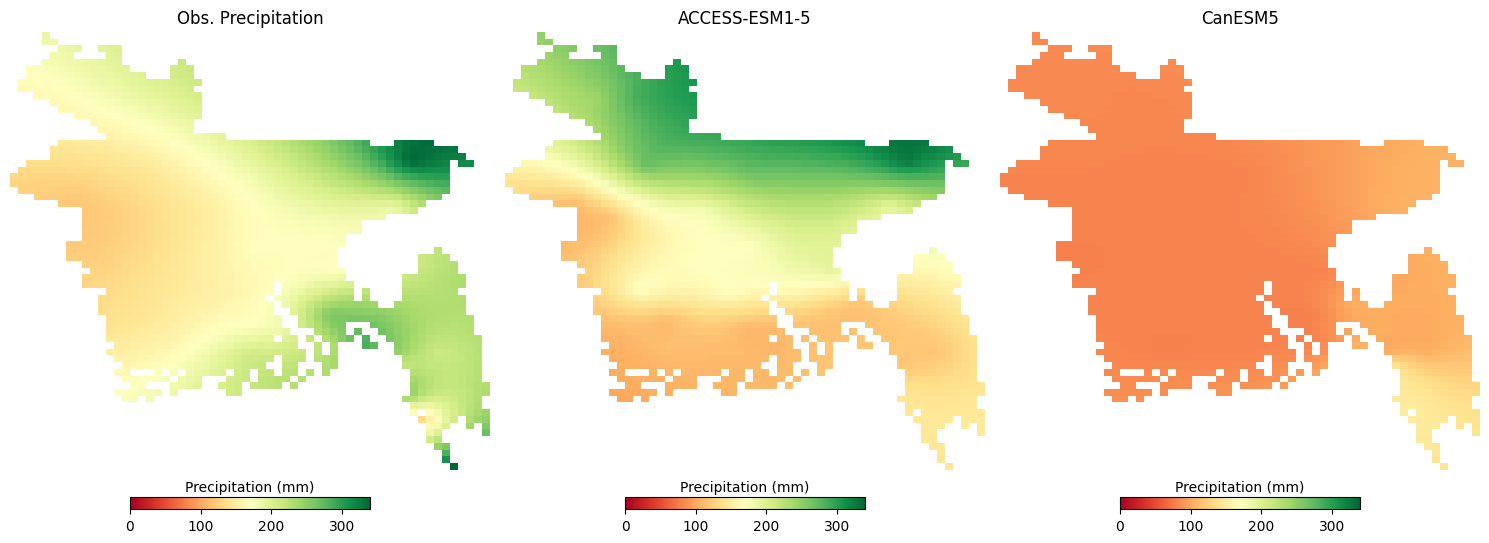

In [23]:
from Interpolate_Clip_Map import interpolated_clipped_map

interpolated_clipped_map(
    df=mean_df,
    variables=[ 'Obs. Precipitation', 'ACCESS-ESM1-5', 'CanESM5'],
    shapefile_path=shapefile_path,
    cmap='RdYlGn',
    figsize=(15, 6),
    cbar_label='Precipitation (mm)',
    method='kriging',
    rows=1,
    cols=3
)

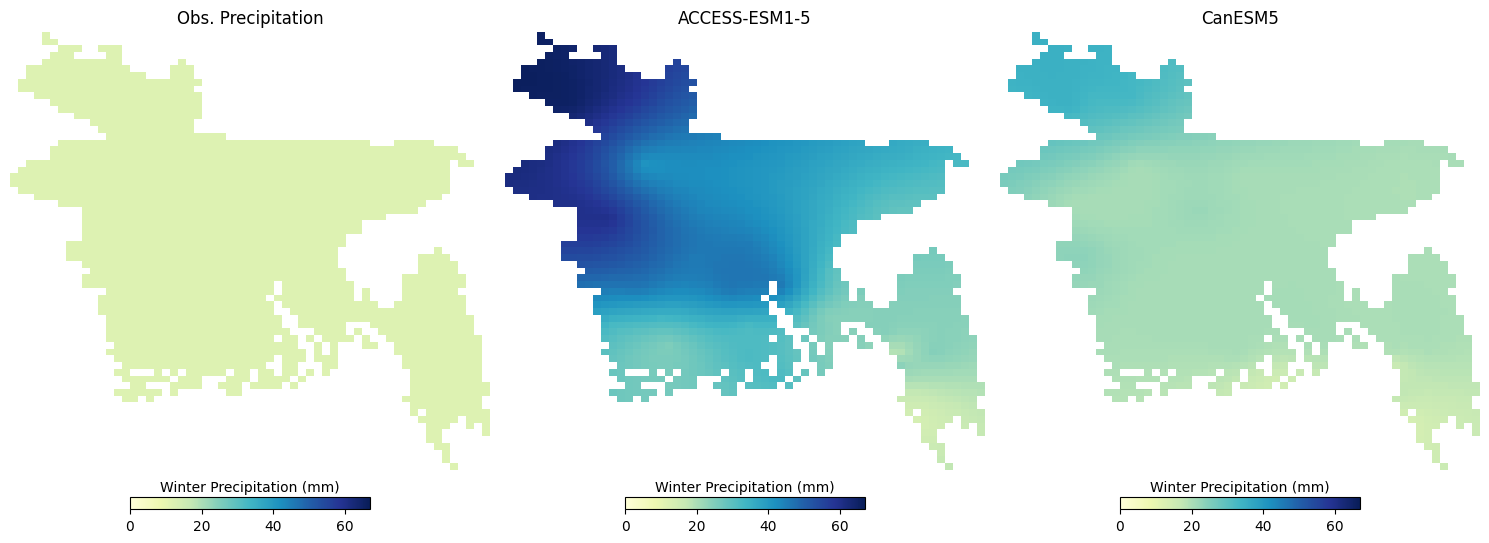

In [30]:
# Step 1–3: Compute monsoon means per model per station
monsoon_mean = []

for df in model_arr:
    monsoon_df = df[df.index.month.isin([12, 1, 2])]  # Filter June–September
    data = {
        'lat': df['lat'].iloc[0],
        'lon': df['lon'].iloc[0],
        'district': df['district'].iloc[0],
        'Obs. Precipitation': monsoon_df['Obs. Precipitation'].mean(),
        'ACCESS-ESM1-5': monsoon_df['ACCESS-ESM1-5'].mean(),
        'CanESM5': monsoon_df['CanESM5'].mean()
    }
    monsoon_mean.append(data)

monsoon_mean_df = pd.DataFrame(monsoon_mean)

# Step 4: Plot interpolated monsoon precipitation
from Interpolate_Clip_Map import interpolated_clipped_map

interpolated_clipped_map(
    df=monsoon_mean_df,
    variables=['Obs. Precipitation', 'ACCESS-ESM1-5', 'CanESM5'],
    shapefile_path=shapefile_path,
    cmap='YlGnBu',
    figsize=(15, 6),
    cbar_label='Winter Precipitation (mm)',
    method='kriging',
    rows=1,
    cols=3
)
